In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import markov_sim as markov
import json
import os
from datetime import datetime
from dateutil import parser
from hampel import hampel
import time
import copy
import preprocessing as p
import score_inference as score

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'
data_list = []


In [188]:
file = '1.145385390.json'

for line in open(file, 'r'):
    data_list.append(json.loads(line))

with open(file, 'r') as f:
    top = f.readline()
    top = json.loads(top)

runner_id = top['mc'][0]['marketDefinition']['runners'][0]['id']
runner_id_2 = top['mc'][0]['marketDefinition']['runners'][1]['id']
market_datetime = parser.parse(data_list[-1]['mc'][0]['marketDefinition']['marketTime'])
r1_result = data_list[-1]['mc'][0]['marketDefinition']['runners'][0]['status']
market_timestamp = datetime.timestamp(market_datetime) * 1000


def get_list(runner_id):
    # Create list for each runner
    runner_list = []
    for instance in data_list:
        if instance['pt'] > market_timestamp:
            if instance['mc'][0]['rc']:
                # Check for runner id
                temp_dict = {k: v for (k, v) in instance['mc'][0]['rc'][0].items() if v == runner_id}
                if temp_dict:
                    # Append runner info
                    runner_list.append([instance['mc'][0]['rc'][0], instance['pt']])
                elif len(instance['mc'][0]['rc']) > 1:
                    # If more than one runner
                    temp_dict_2 = {k: v for (k, v) in instance['mc'][0]['rc'][1].items() if v == runner_id}
                    if temp_dict_2:
                        runner_list.append([instance['mc'][0]['rc'][1], instance['pt']])
    return runner_list


def convert_odds(runner_list):
    # Convert to back/lay/last traded odds

    list = []

    for item in runner_list:
        if 'ltp' in item[0]:
            list.append([item[0]['ltp'], item[1]])

    del list[-1]
    arr = np.array(list)
    arr = arr[arr[:, 0] != 0]
    implied_odds = np.array([1 / arr[:, 0], arr[:, 1]]).T

    return implied_odds


# Find avg ltp odds
def odds_avg(runner_1, runner_2):
    if runner_1[-1, 1] > runner_2[-1, 1]:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_1[-1, 1] + 1, -2), 100)
    else:
        if runner_1[1, 1] > runner_2[1, 1]:
            timestamps = np.arange(round(runner_2[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)
        else:
            timestamps = np.arange(round(runner_1[1, 1], -2), round(runner_2[-1, 1] + 1, -2), 100)

    odds = np.zeros(np.shape(timestamps))
    df_timestamps = pd.Series(timestamps)

    df_datetime = pd.to_datetime(df_timestamps, unit='ms')

    df = pd.DataFrame({'runner 1': odds, '1 - runner 2': odds}, index=df_datetime)

    for index, time in enumerate(runner_1[:, 1]):
        df['runner 1'].loc[pd.to_datetime(round(time, -2), unit='ms')] = runner_1[index, 0]

    for index, time in enumerate(runner_2[:, 1]):
        df['1 - runner 2'].loc[pd.to_datetime(round(time, -2), unit='ms')] = 1 - runner_2[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df['avg'] = df.mean(axis=1)
    df_avg_odds = df.resample('2000ms').last()
    last_index = df_avg_odds.last_valid_index() + pd.Timedelta(2, 'sec')
    final_index = last_index + pd.Timedelta(12, 'sec')
    df_datetime = pd.date_range(last_index, final_index, freq='2000ms')
    print(df_datetime)
    if r1_result == 'WINNER':
        df_ones = pd.DataFrame({'runner 1': np.ones(7), '1 - runner 2': np.ones(7), 'avg': np.ones(7)}, index=df_datetime)
        df_avg_odds = pd.concat([df_avg_odds, df_ones])
    else:
        df_zeros = pd.DataFrame({'runner 1': np.zeros(7), '1 - runner 2': np.zeros(7), 'avg': np.zeros(7)}, index=df_datetime)
        df_avg_odds = pd.concat([df_avg_odds, df_zeros])
    print(df_avg_odds)
    return df_avg_odds

def get_best_pricevol(runner_list, price, vol):
# Function to get best lay and back information
    back_list = []
    lay_list = []

    back_vol = []
    lay_vol = []

    for item in runner_list:
        if 'atl' in item[0]:
            if len(item[0]['atl']) > 1:
                temp = []
                for i in item[0]['atl']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    back_list.append([temp.min(), item[1]])
                    back_vol.append([item[0]['atl'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atl'][0][1] != 0:
                    back_list.append([item[0]['atl'][0][0], item[1]])
                    back_vol.append([item[0]['atl'][0][1], item[1]])

    for item in runner_list:
        if 'atb' in item[0]:
            if len(item[0]['atb']) > 1:
                temp = []
                for i in item[0]['atb']:
                    if i[1] != 0:
                        temp.append(i[0])
                if temp:
                    temp = np.array(temp)
                    lay_list.append([temp.max(), item[1]])
                    lay_vol.append([item[0]['atb'][temp.argmax()][1], item[1]])
            else:
                if item[0]['atb'][0][1] != 0:
                    lay_list.append([item[0]['atb'][0][0], item[1]])
                    lay_vol.append([item[0]['atb'][0][1], item[1]])

    del back_list[-1], lay_list[-1], back_vol[-1], lay_vol[-1]

    back_vol_arr = np.array(back_vol)
    lay_vol_arr = np.array(lay_vol)
    back_arr = np.array(back_list)
    lay_arr = np.array(lay_list)

    back_series = pd.Series(back_arr[:, 0], index=pd.to_datetime(back_arr[:, 1], unit='ms'))
    lay_series = pd.Series(lay_arr[:, 0], index=pd.to_datetime(lay_arr[:, 1], unit='ms'))
    back_vol_series = pd.Series(back_vol_arr[:, 0], index=pd.to_datetime(back_vol_arr[:, 1], unit='ms'))
    lay_vol_series = pd.Series(lay_vol_arr[:, 0], index=pd.to_datetime(lay_vol_arr[:, 1], unit='ms'))
# Apply hampel filter to remove outliers
    back_outliers = hampel(back_series, window_size=80)
    lay_outliers = hampel(lay_series, window_size=80)
    back_vol_outliers = hampel(back_vol_series, window_size=15)
    lay_vol_outliers = hampel(lay_vol_series, window_size=15)

    back_arr = np.delete(back_arr, back_outliers, axis=0)
    lay_arr = np.delete(lay_arr, lay_outliers, axis=0)
    back_vol_arr = np.delete(back_vol_arr, back_vol_outliers, axis=0)
    lay_vol_arr = np.delete(lay_vol_arr, lay_vol_outliers, axis=0)

    if price and not vol:
        return back_arr, lay_arr
    elif vol and not price:
        return back_vol_arr, lay_vol_arr

    return back_arr, lay_arr, back_vol_arr, lay_vol_arr

def best_available_df(runner_list, start, end):
# Get back and lay information and calculate spread and price up probability
    end_time = end + pd.Timedelta(120, 'sec')
    df_datetime = pd.date_range(start, end_time, freq='100ms')
    df_datetime = df_datetime.floor('100ms')
    dt_shape = np.zeros(df_datetime.shape)

    back_arr, lay_arr, back_vol_arr, lay_vol_arr = get_best_pricevol(runner_list, True, True)

    df = pd.DataFrame({'back': dt_shape, 'lay': dt_shape, 'back_vol': dt_shape, 'lay_vol': dt_shape}, index=df_datetime)

    for index, time in enumerate(back_arr[:, 1]):
        df['back'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_arr[index, 0]
    for index, time in enumerate(lay_arr[:, 1]):
        df['lay'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_arr[index, 0]

    for index, time in enumerate(back_vol_arr[:, 1]):
        df['back_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = back_vol_arr[index, 0]
    for index, time in enumerate(lay_vol_arr[:, 1]):
        df['lay_vol'].loc[pd.to_datetime(round(time, -2), unit='ms')] = lay_vol_arr[index, 0]

    df.replace(0, np.nan, inplace=True)
    df.interpolate(method='time', limit_direction='both', inplace=True)

    _2000ms = df.index.floor('2000ms')
    idx_back = df.groupby(_2000ms)['back'].idxmin()
    idx_lay = df.groupby(_2000ms)['lay'].idxmax()
    df = df.resample('2000ms').mean().assign(back=df.loc[idx_back]['back'].values,
                                            back_vol=df.loc[idx_back]['back_vol'].values,
                                            lay=df.loc[idx_lay]['lay'].values,
                                            lay_vol=df.loc[idx_lay]['lay_vol'].values)

    df_best = df.rolling('60S').mean()
    df_best = df_best.loc[start:end]
    # last_index = end + pd.Timedelta(1, 'sec')
    # final_index = last_index + pd.Timedelta(59, 'sec')
    # df_datetime_new = pd.date_range(last_index, final_index, freq='2000ms')
    # print(end, last_index)
    # if r1_result == 'WINNER':
    #     df_ones = pd.DataFrame({'back': np.repeat(1000, 60), 'back_vol': np.zeros(60), 'lay': np.repeat(1000, 60), 'lay_vol': np.repeat(0.001, 60)}, index=df_datetime_new)
    #     df_best = pd.concat([df_best, df_ones])
    # else:
    #     df_zeros = pd.DataFrame({'back': np.ones(60), 'back_vol': np.zeros(60), 'lay': np.ones(60), 'lay_vol': np.repeat(0.001, 60)}, index=df_datetime_new)
    #     df_best = pd.concat([df, df_zeros])
    df_best['back-lay avg'] = df_best[['back', 'lay']].mean(axis=1)
    df_best['spread'] = df_best['back'] - df_best['lay']
    df_best['vol diff'] = df_best['back_vol'] - df_best['lay_vol']
    df_best['uncertainty'] = df_best['spread'] / df_best['back-lay avg']
    df_pup = df_best['back_vol'] / ( df_best['back_vol'] + df_best['lay_vol'] )
    df_pup.name = 'pup'
    df_best = pd.concat([df_best, df_pup], axis=1)
    df_best.fillna(method='ffill', inplace=True)

    return df_best

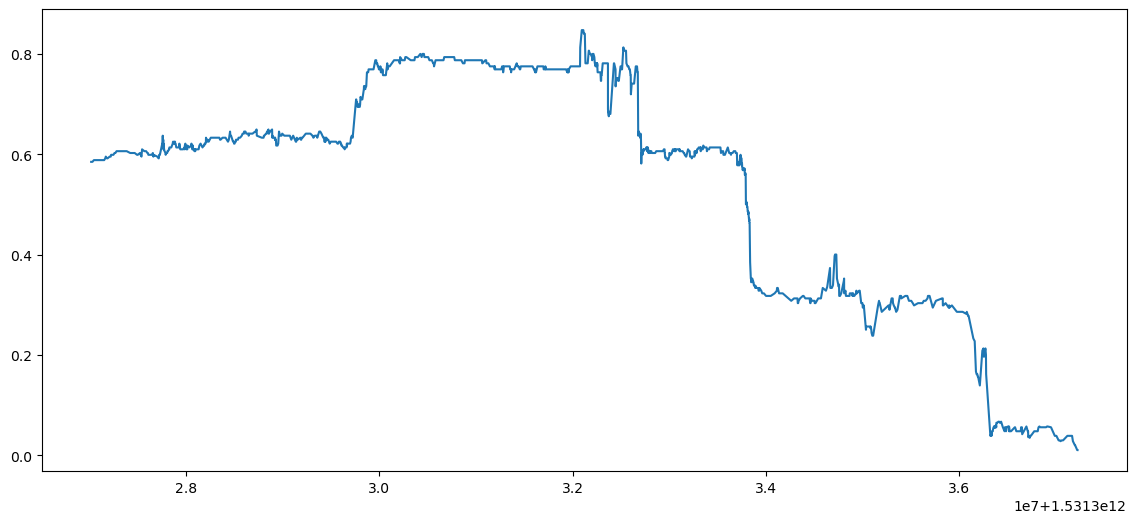

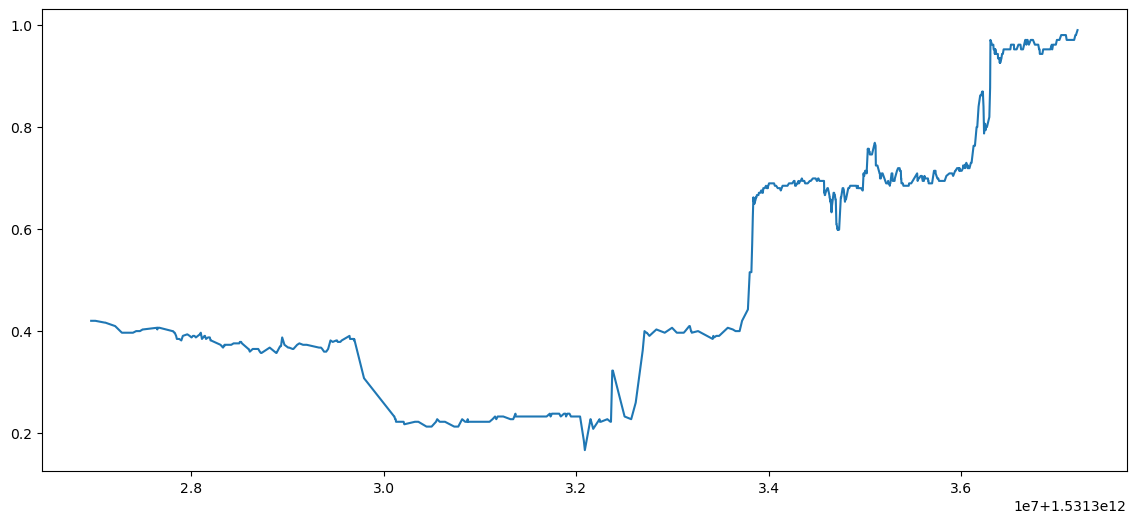

In [189]:
runner_list_1 = get_list(runner_id)
runner_list_2 = get_list(runner_id_2)
runner_odds_1 = convert_odds(runner_list_1)
runner_odds_2 = convert_odds(runner_list_2)
plt.figure(figsize=(14,6))
plt.plot(runner_odds_1[:, 1], runner_odds_1[:, 0])
plt.figure(figsize=(14,6))
plt.plot(runner_odds_2[:, 1], runner_odds_2[:, 0])


In [190]:
df = odds_avg(runner_odds_1, runner_odds_2)

DatetimeIndex(['2018-07-11 19:27:04', '2018-07-11 19:27:06',
               '2018-07-11 19:27:08', '2018-07-11 19:27:10',
               '2018-07-11 19:27:12', '2018-07-11 19:27:14',
               '2018-07-11 19:27:16'],
              dtype='datetime64[ns]', freq='2000L')
                     runner 1  1 - runner 2       avg
2018-07-11 16:36:42  0.584795      0.579832  0.582314
2018-07-11 16:36:44  0.584795      0.579905  0.582350
2018-07-11 16:36:46  0.584795      0.579978  0.582387
2018-07-11 16:36:48  0.584795      0.580051  0.582423
2018-07-11 16:36:50  0.584795      0.580124  0.582460
...                       ...           ...       ...
2018-07-11 19:27:08  0.000000      0.000000  0.000000
2018-07-11 19:27:10  0.000000      0.000000  0.000000
2018-07-11 19:27:12  0.000000      0.000000  0.000000
2018-07-11 19:27:14  0.000000      0.000000  0.000000
2018-07-11 19:27:16  0.000000      0.000000  0.000000

[5118 rows x 3 columns]


0.5960834770893242
0.667
0.673


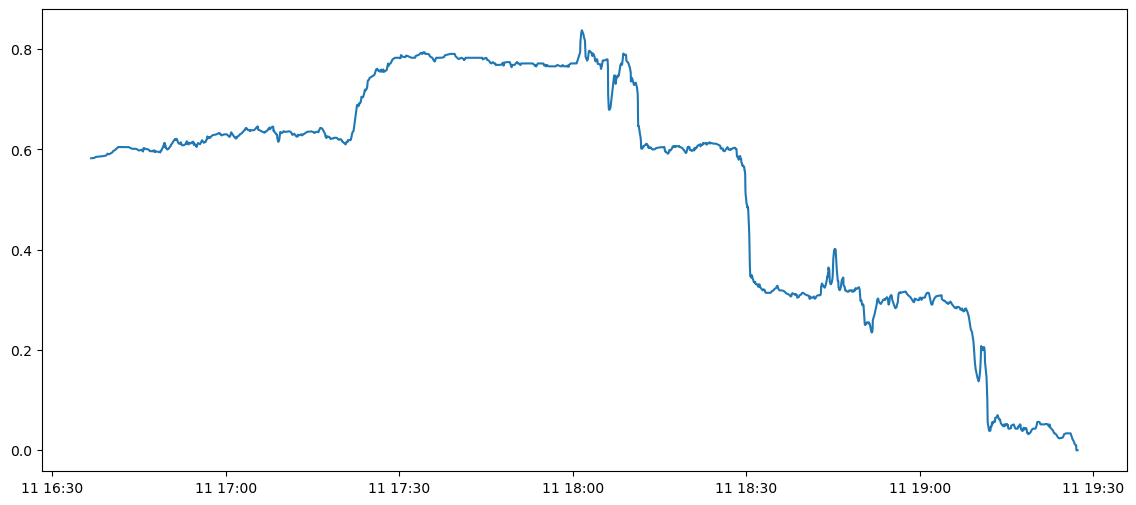

In [191]:
plt.figure(figsize=(14,6))
plt.plot(df['avg'])
first_odds = df['avg'].iloc[0:300].mean()
print(first_odds)
r1, r2 = 0.667, 0.673
print(r1)
print(r2)

In [192]:
df_score = score.get_score_time_series(r1, r2, df['avg'], 1)

0.687 0.673 0.4768134496386584 0.3555137967321441 0.582313627205268 0-0 1-0
0.687 0.674 0.6966182892666003 0.576379845742853 0.5823501762716587 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.5823867253380492 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.58242327440444 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.5824598234708307 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.5824963725372212 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.5825329216036119 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.5825694706700026 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.5826060197363931 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.5826425688027839 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.5826791178691745 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.5827156669355651 0-0 1-0
0.687 0.674 0.6916910902242848 0.5705276029270931 0.5827522160019558 0-0 1-0
0.6

KeyboardInterrupt: 

In [178]:
df_score

,r1_gs,r2_gs,r1_setscore,r2_setscore
2018-07-11 16:36:00,1,0,0,0
2018-07-11 16:37:00,1,0,0,0
2018-07-11 16:38:00,1,0,0,0
2018-07-11 16:39:00,1,0,0,0
2018-07-11 16:40:00,1,0,0,0
...,...,...,...,...
2018-07-11 19:29:00,2,2,0,2
2018-07-11 19:30:00,2,3,0,2
2018-07-11 19:31:00,2,4,0,2
2018-07-11 19:32:00,2,5,0,2


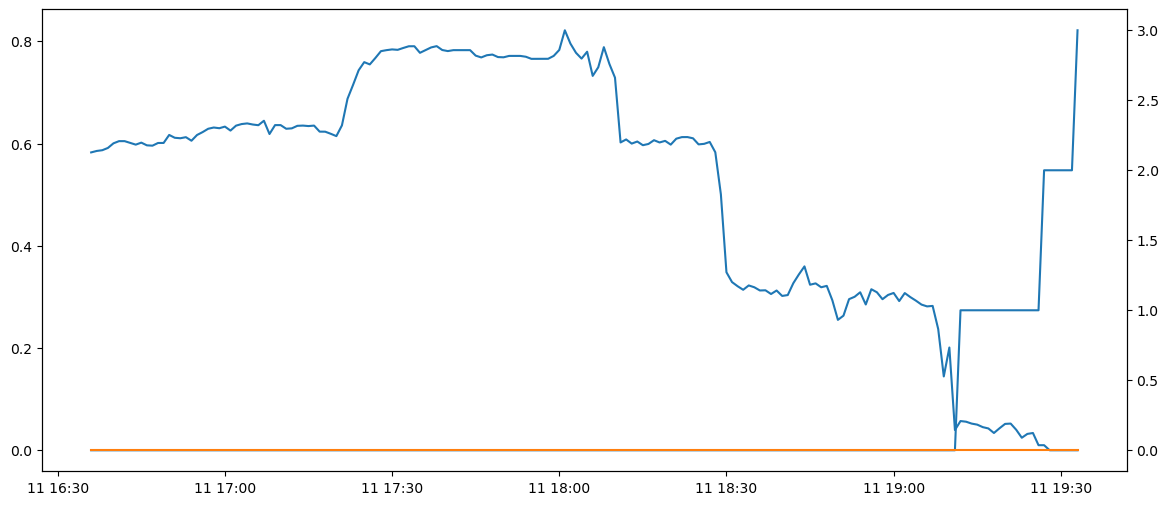

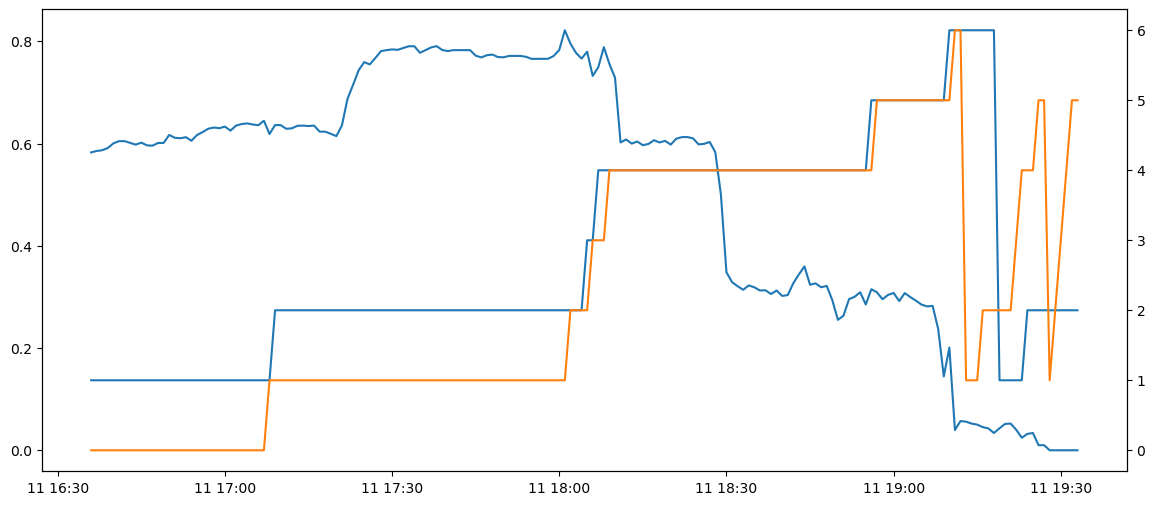

In [179]:
fig, ax = plt.subplots(figsize=(14,6))
ax.plot(df['avg'])
ax2 = ax.twinx()
ax2.plot(df_score['r2_setscore'])
ax2.plot(df_score['r1_setscore'])
fig, ax1 = plt.subplots(figsize=(14,6))
ax1.plot(df['avg'])
ax3 = ax1.twinx()
ax3.plot(df_score['r1_gs'])
ax3.plot(df_score['r2_gs'])

In [180]:
start = df.first_valid_index()
end = df.last_valid_index()
df_runner_1 = best_available_df(runner_list_1, start, end)
df_runner_1

,back,lay,back_vol,lay_vol,back-lay avg,spread,vol diff,uncertainty,pup
2018-07-11 16:36:00,1.72,1.71,168.530000,1943.850000,1.715,0.01,-1775.320000,0.005831,0.079782
2018-07-11 16:37:00,1.71,1.71,168.530000,3390.622857,1.710,0.00,-3222.092857,0.000000,0.047351
2018-07-11 16:38:00,1.71,1.70,266.932222,4900.343200,1.705,0.01,-4633.410978,0.005865,0.051658
2018-07-11 16:39:00,1.69,1.70,465.670000,5161.989677,1.695,-0.01,-4696.319677,-0.005900,0.082747
2018-07-11 16:40:00,1.67,1.68,459.310000,3530.150000,1.675,-0.01,-3070.840000,-0.005970,0.115131
...,...,...,...,...,...,...,...,...,...
2018-07-11 19:29:00,40.00,4.50,5.580000,21.480000,22.250,35.50,-15.900000,1.595506,0.206208
2018-07-11 19:30:00,40.00,4.50,5.580000,21.480000,22.250,35.50,-15.900000,1.595506,0.206208
2018-07-11 19:31:00,40.00,4.50,5.580000,21.480000,22.250,35.50,-15.900000,1.595506,0.206208
2018-07-11 19:32:00,40.00,4.50,5.580000,21.480000,22.250,35.50,-15.900000,1.595506,0.206208


In [181]:
df_runner_2 = best_available_df(runner_list_2, start, end)
df_runner_2

,back,lay,back_vol,lay_vol,back-lay avg,spread,vol diff,uncertainty,pup
2018-07-11 16:36:00,2.40,2.38,1.370000,1763.89,2.390,0.02,-1762.520000,0.008368,0.000776
2018-07-11 16:37:00,2.40,2.40,47.981727,143.90,2.400,0.00,-95.918273,0.000000,0.250059
2018-07-11 16:38:00,2.42,2.40,257.172798,1361.98,2.410,0.02,-1104.807202,0.008299,0.158832
2018-07-11 16:39:00,2.42,2.44,31.568493,756.45,2.430,-0.02,-724.881507,-0.008230,0.040061
2018-07-11 16:40:00,2.46,2.48,224.940000,1054.31,2.470,-0.02,-829.370000,-0.008097,0.175837
...,...,...,...,...,...,...,...,...,...
2018-07-11 19:29:00,1.06,1.01,2017.260000,763.16,1.035,0.05,1254.100000,0.048309,0.725523
2018-07-11 19:30:00,1.06,1.01,2017.260000,763.16,1.035,0.05,1254.100000,0.048309,0.725523
2018-07-11 19:31:00,1.06,1.01,2017.260000,763.16,1.035,0.05,1254.100000,0.048309,0.725523
2018-07-11 19:32:00,1.06,1.01,2017.260000,763.16,1.035,0.05,1254.100000,0.048309,0.725523


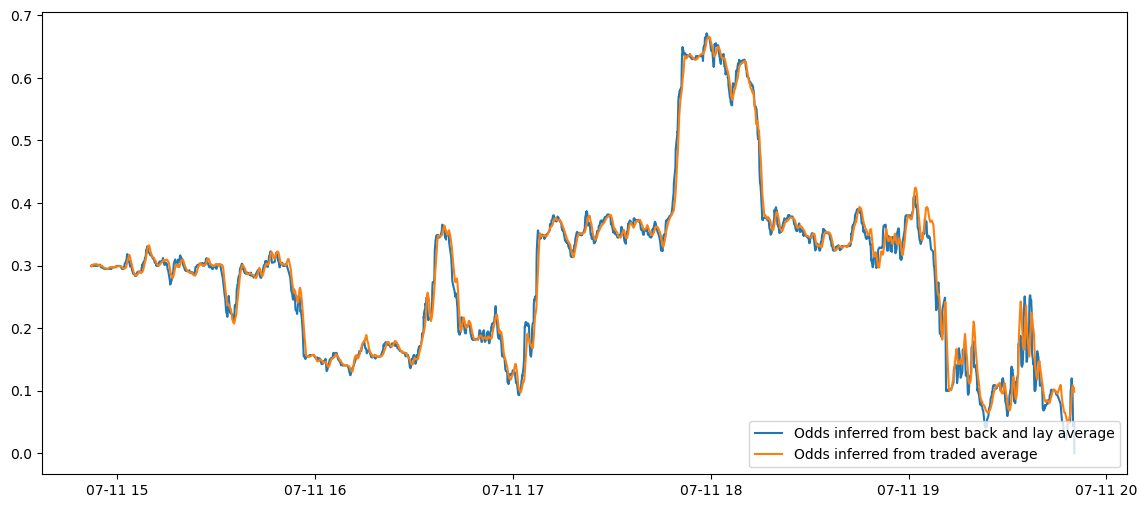

In [21]:
df_avg = df['avg']
df_blodds = ( 1 / df_runner_1['back-lay avg'] + 1 - 1 / df_runner_2['back-lay avg'] ) / 2
df_odds = pd.concat([df_avg, df_blodds], axis=1)
df_odds.columns = ['ltp odds', 'back lay odds']
df_odds
plt.figure(figsize=(14,6))
plt.plot(df_odds)
plt.legend(['Odds inferred from best back and lay average', 'Odds inferred from traded average'], loc='lower right')

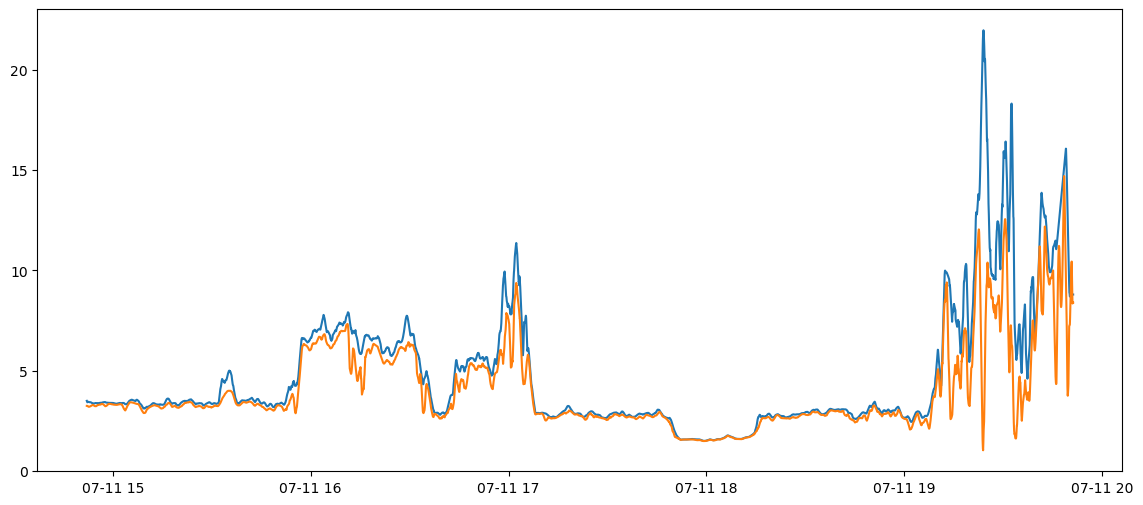

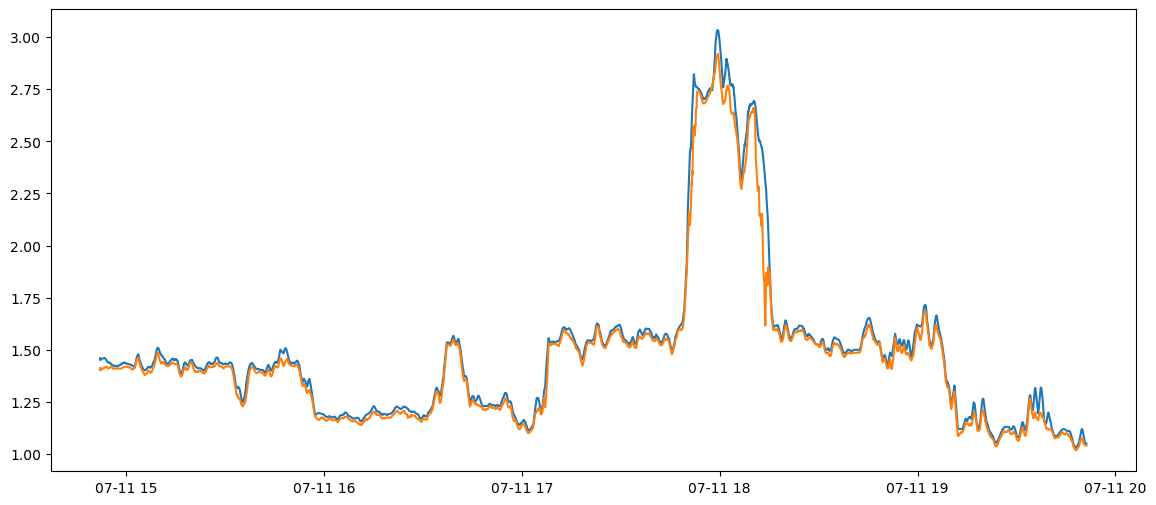

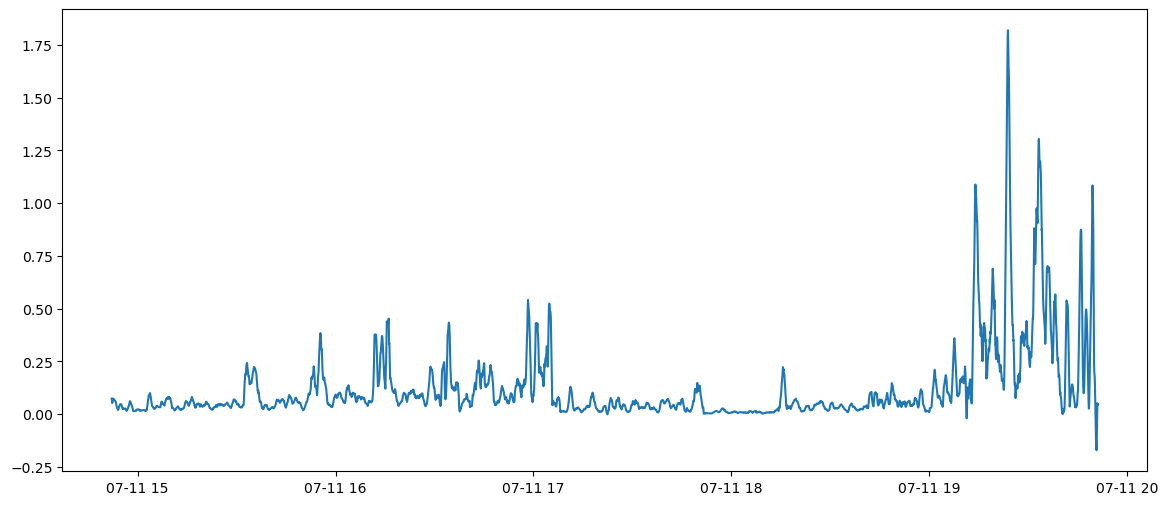

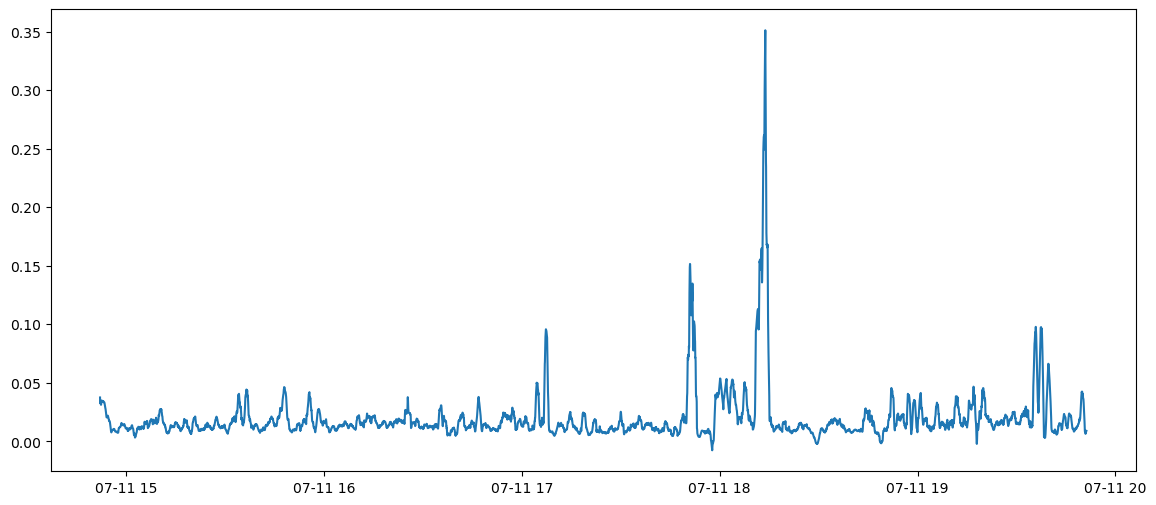

In [23]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back','lay']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['uncertainty']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['uncertainty']])

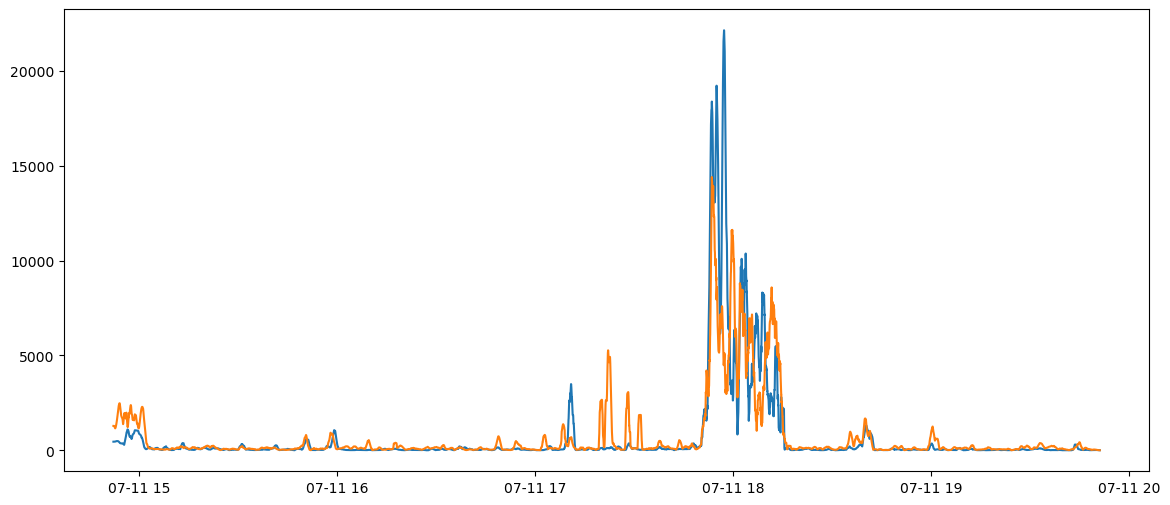

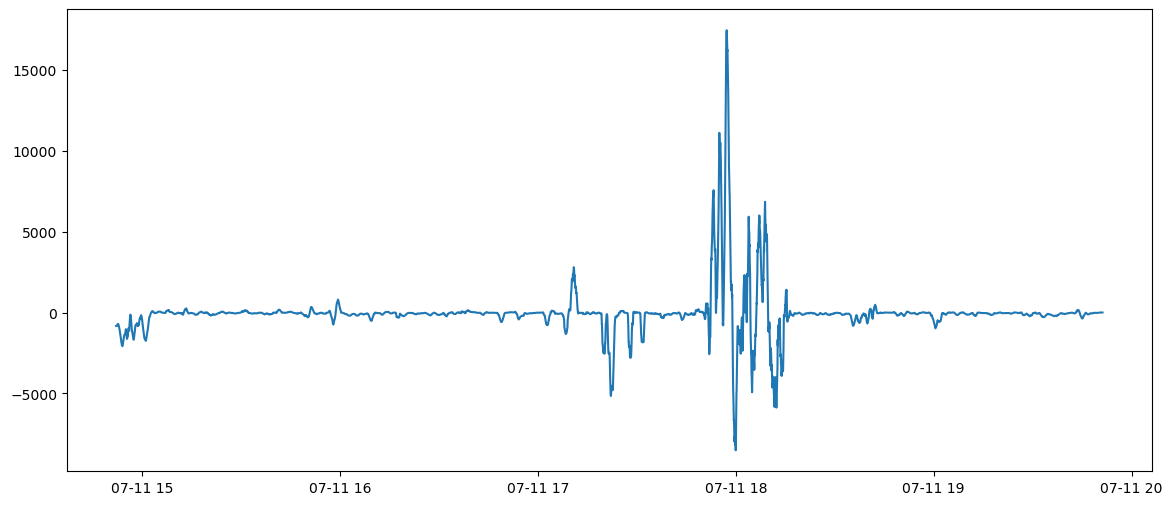

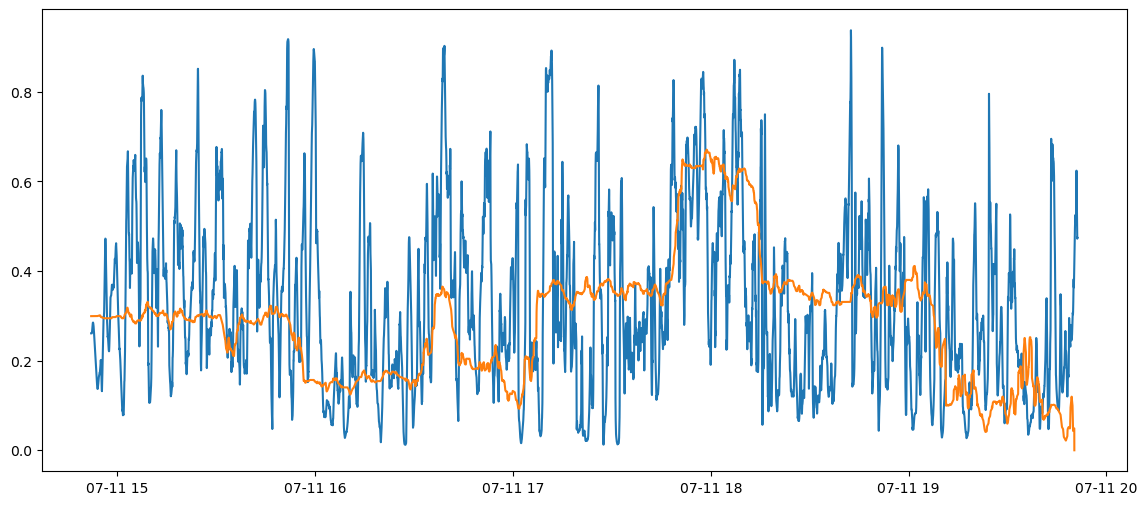

In [24]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['back_vol']])
plt.plot(df_runner_1[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_1[['pup']])
plt.plot(df_odds['ltp odds'])

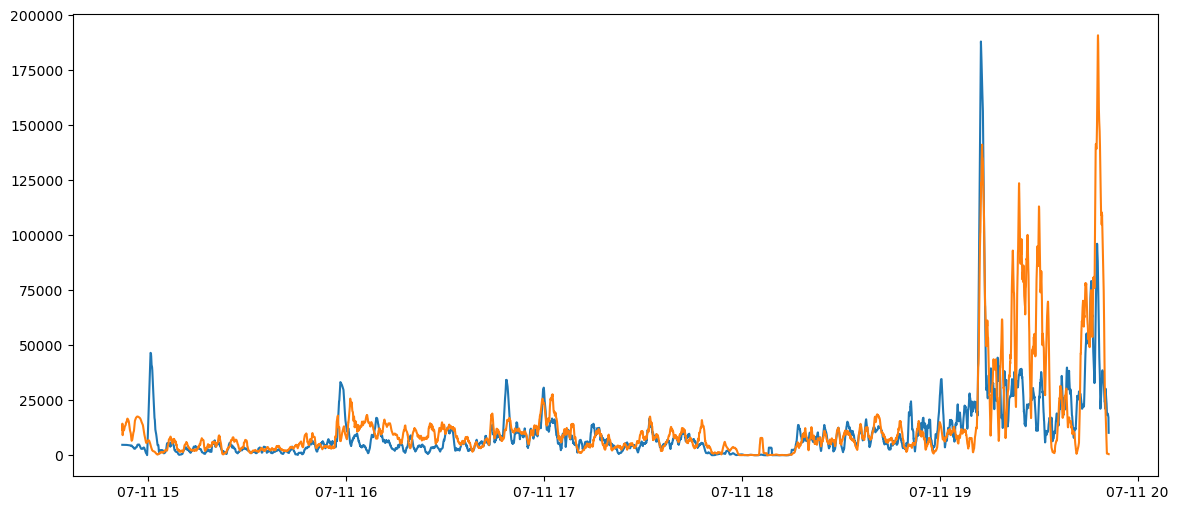

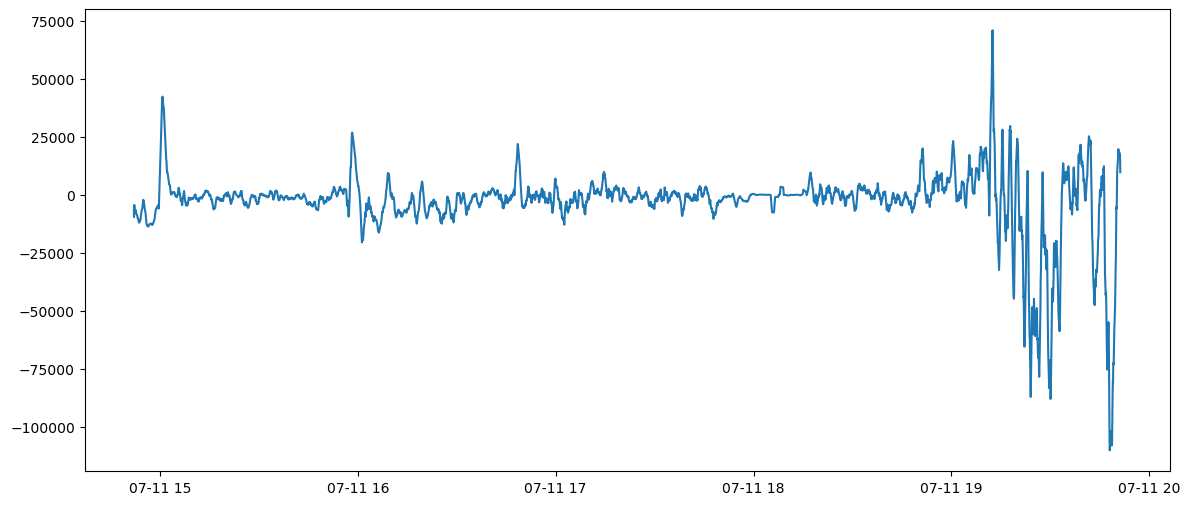

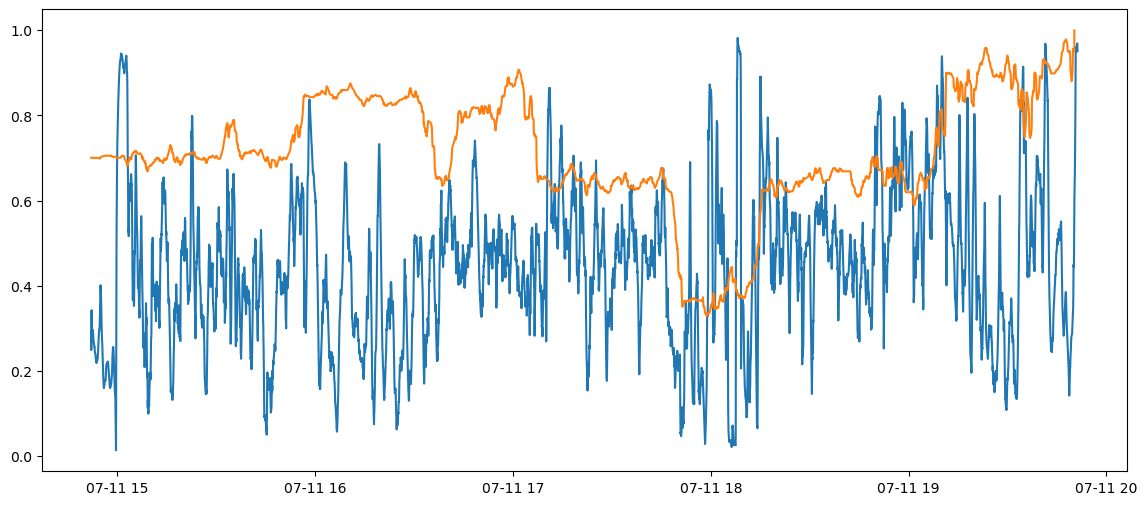

In [25]:
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['back_vol']])
plt.plot(df_runner_2[['lay_vol']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['vol diff']])
plt.figure(figsize=(14,6))
plt.plot(df_runner_2[['pup']])
plt.plot(1 - df_odds['ltp odds'])
df_total = pd.DataFrame({'lpt odds': df_odds['ltp odds'], 'r1 spread': df_runner_1['uncertainty'], 'r1 pup': df_runner_1['pup'], 'r2 spread': df_runner_2['uncertainty'], 'r2 pup': df_runner_2['pup']}, index=df_odds.index)
df_total
df_total.to_csv('Data/1.csv')